# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize as resize1
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
import gym
import tensorforce
from tensorforce import Agent, Environment

from PIL import Image
import torchvision.transforms as T
import torch

import math
import random
import numpy as np

C:\Anaconda\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
import retro
import time
from tensorforce import Agent, Environment

## Cargar agente y definición de entorno

In [3]:
agent = Agent.load(directory='DQN-SPACEINVADERS-NES-VISION-HALF-GRAYSCALE-DISCRETIZADO')

In [4]:
class Discretizer(gym.ActionWrapper):
    """
    Wrap a gym environment and make it use discrete actions.
    Args:
        combos: ordered list of lists of valid button combinations
    """

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False] * env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class SpaceInvadersNesDiscretizer(Discretizer):
    def __init__(self, env):
      # We allow the character to stay still, move either way, or shoot standing still.
      super().__init__(env=env, combos=[['LEFT'], ['RIGHT'], ['A']])

In [5]:
env = retro.make(game='SpaceInvaders-Nes')
env = SpaceInvadersNesDiscretizer(env)
environment = Environment.create(environment=env)

In [23]:
print(env._decode_discrete_action)

[array([False, False, False, False, False, False,  True, False, False]), array([False, False, False, False, False, False, False,  True, False]), array([False, False, False, False, False, False, False, False,  True])]


In [25]:
buttons = env.unwrapped.buttons
print(buttons)

['B', None, 'SELECT', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'A']


224


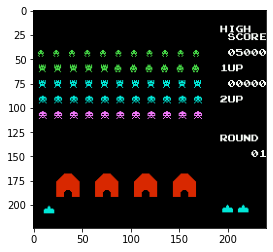

In [27]:
agent.tracked_tensors()
states = environment.reset()
print(states.shape[0])
img_ = Image.fromarray(states, 'RGB')
plt.imshow(img_)

## Métodos específicos RISE

In [6]:
def generate_masks(N, s, p1, dimx = 40, dimy = 90):
    cell_size = np.ceil(np.array((dimx,dimy)) / s) # si dividimos en s "cachos" dim entera
    up_size = (s + 1) * cell_size # si cupiese uno mas dim
    
    grid = np.random.rand(N, s, s) < p1 #generar cuadrado s * s con 0 o 1
    grid = grid.astype('float32')
    masks = np.empty((N, dimx,dimy)) #lo rellenaremos

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0]) #cuando shift en x
        y = np.random.randint(0, cell_size[1]) #cuanto shift en y
        # Linear upsampling and cropping
        masks[i, :, :] = resize1(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + dimx, y:y + dimy]
        
    masks = masks.reshape(-1, dimx,dimy , 1)
    return masks

In [7]:
def explain(inp, masks , agent, dimx = 40, dimy = 90):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    
    #print(masked.shape) # = (2000, 40, 90, 3) => N alteraciones de la imagen x 
    for i in tqdm(range (0,N), desc = 'Explaining'):
        decision = agent.act(states=masked[i], independent = True)
        elem = agent.tracked_tensors()['agent/policy/action-values']
        softmax = tf.nn.softmax(elem).numpy()
        preds.append(softmax)
    
    preds = np.array(preds)
    

    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, dimx,dimy)
    sal = sal / N / p1
    return sal


In [8]:
combos=[['LEFT'], ['RIGHT'], ['A']]
def saliency(class_idx,img, sal):
    plt.title('Explanation for `{}`'.format(combos[class_idx]))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
    plt.show()

## Creación de la explicación

In [9]:
states = environment.reset()
terminal = False
#constantes generacion mascaras
N = 2000
s = 8
p1 = 0.9
masks = generate_masks(N, s, p1,states.shape[0],states.shape[1])

Generating masks: 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 297.05it/s]


Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.07it/s]


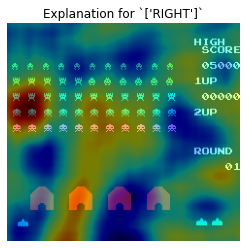

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.04it/s]


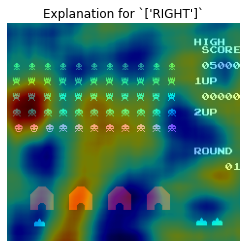

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.89it/s]


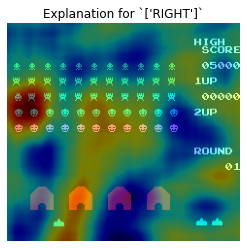

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 76.96it/s]


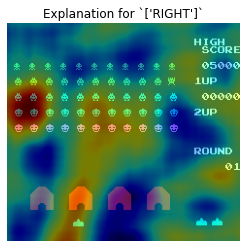

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.05it/s]


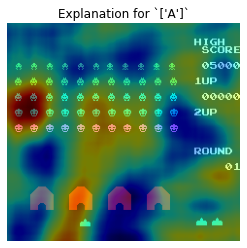

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.18it/s]


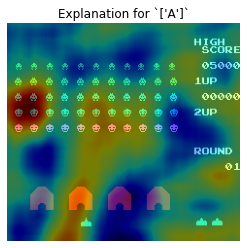

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.03it/s]


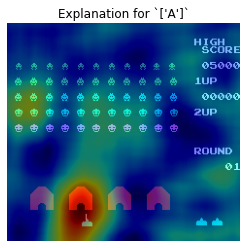

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.05it/s]


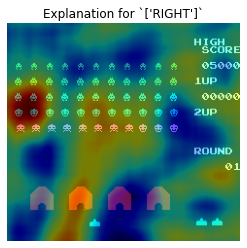

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.49it/s]


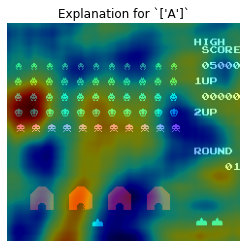

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.12it/s]


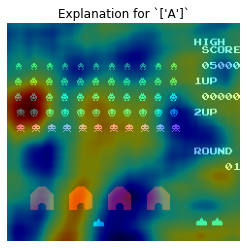

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.83it/s]


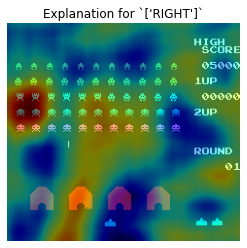

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.96it/s]


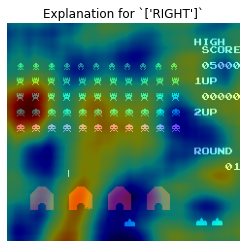

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.71it/s]


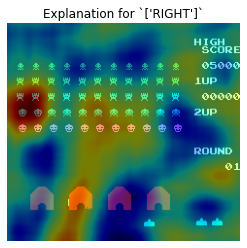

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.41it/s]


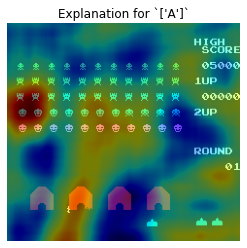

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.95it/s]


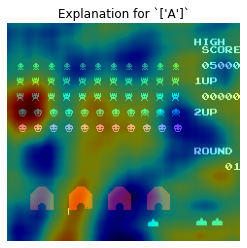

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 74.04it/s]


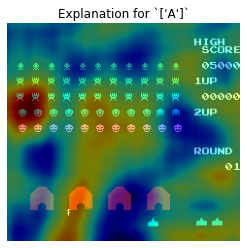

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.27it/s]


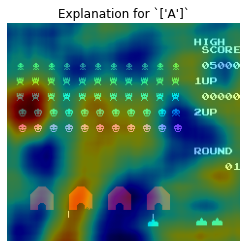

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.56it/s]


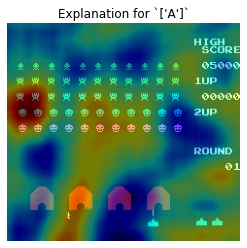

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.44it/s]


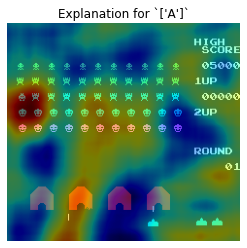

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.16it/s]


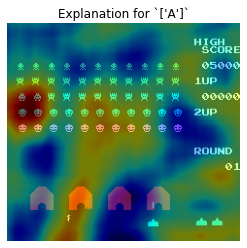

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.65it/s]


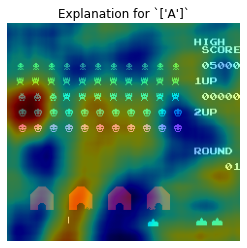

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.37it/s]


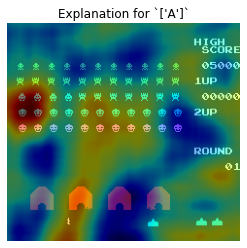

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.96it/s]


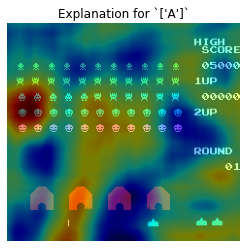

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.22it/s]


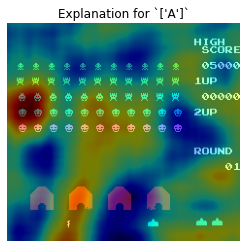

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.42it/s]


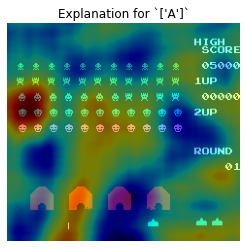

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.30it/s]


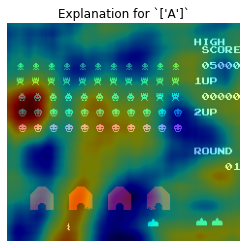

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.06it/s]


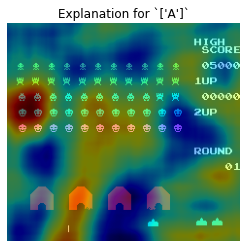

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.86it/s]


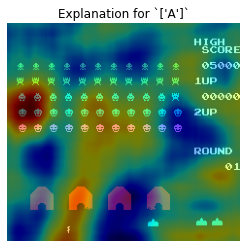

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.76it/s]


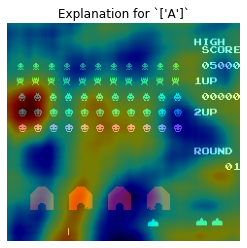

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.31it/s]


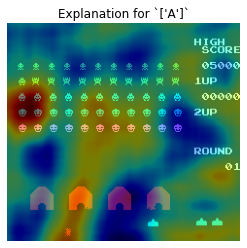

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.38it/s]


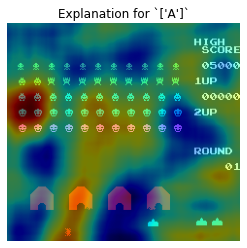

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.11it/s]


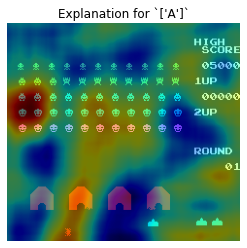

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.27it/s]


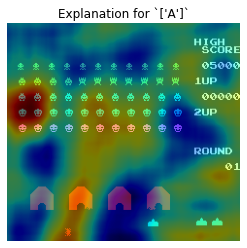

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.19it/s]


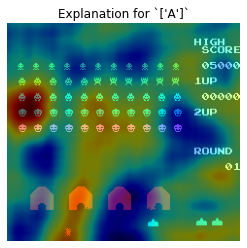

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.71it/s]


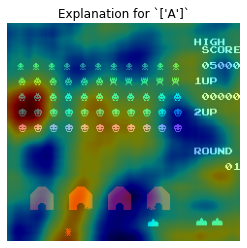

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.34it/s]


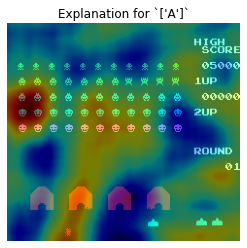

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.93it/s]


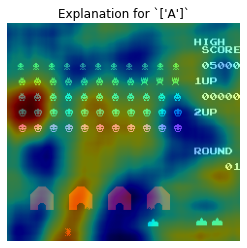

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.51it/s]


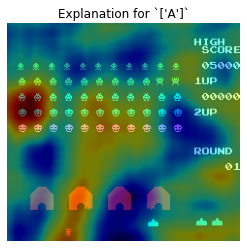

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.51it/s]


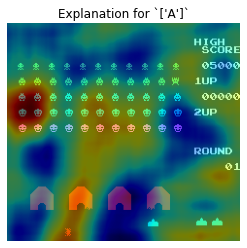

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.23it/s]


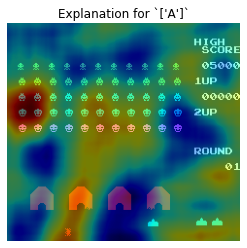

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.36it/s]


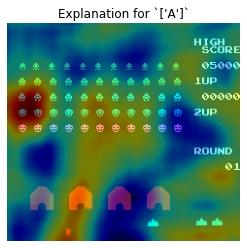

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.09it/s]


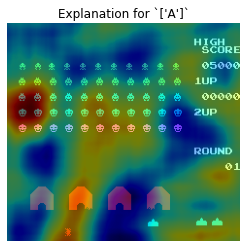

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.36it/s]


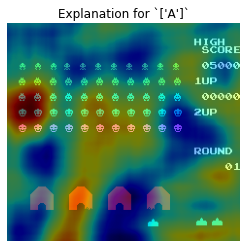

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.25it/s]


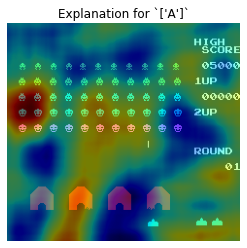

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.12it/s]


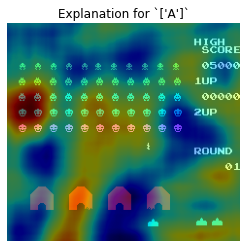

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.81it/s]


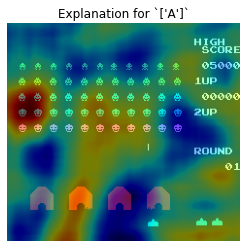

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.40it/s]


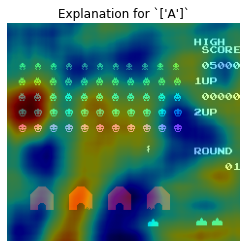

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.82it/s]


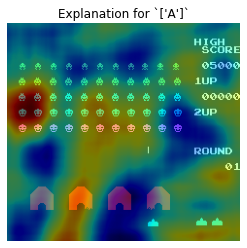

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.40it/s]


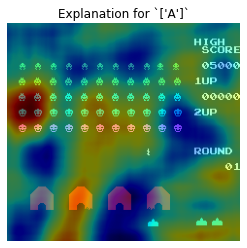

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.67it/s]


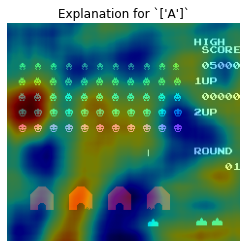

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.31it/s]


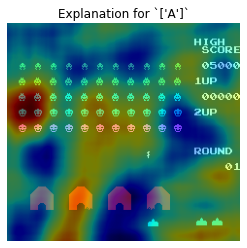

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.92it/s]


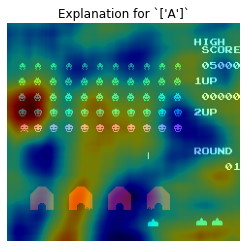

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.35it/s]


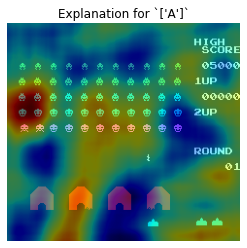

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.97it/s]


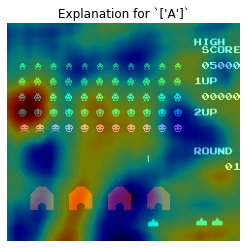

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.85it/s]


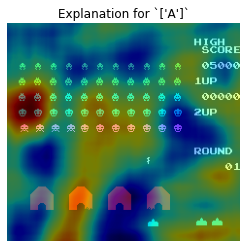

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.17it/s]


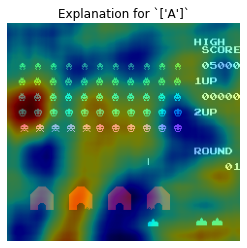

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.62it/s]


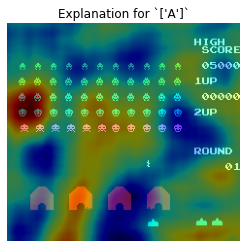

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.81it/s]


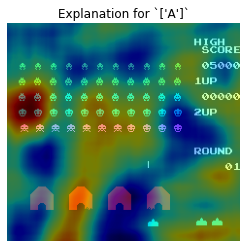

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.40it/s]


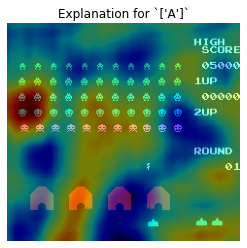

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.02it/s]


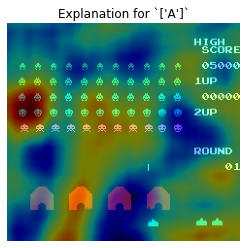

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.28it/s]


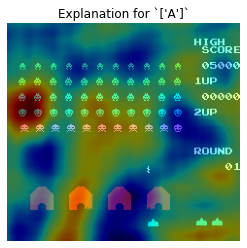

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.75it/s]


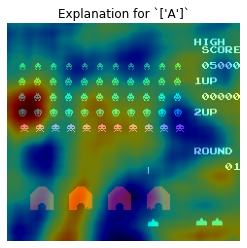

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.19it/s]


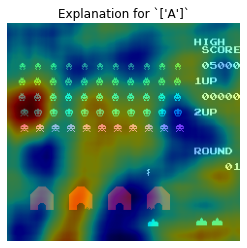

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.02it/s]


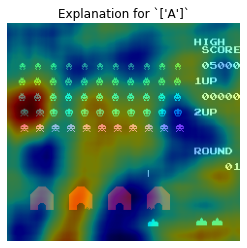

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.01it/s]


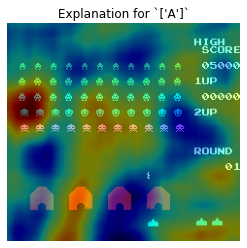

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.16it/s]


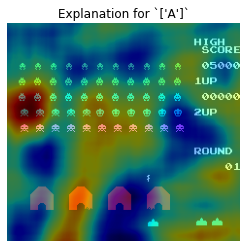

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.73it/s]


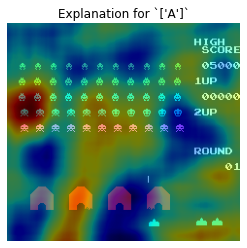

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.76it/s]


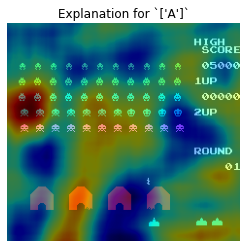

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.19it/s]


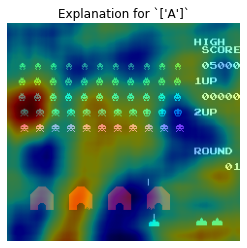

Explaining: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.44it/s]


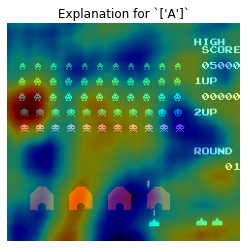

Explaining:  31%|████████████████████▊                                              | 621/2000 [00:08<00:18, 75.77it/s]

In [ ]:
i=0
while(not terminal):
    img = Image.fromarray(states, 'RGB')
    actions = agent.act(states=states)
    if i % 20 == 0 or actions == 2:
        sal = explain(states, masks , agent,states.shape[0],states.shape[1])
        saliency(actions,img,sal)
    states, terminal, reward = environment.execute(actions=actions)
    agent.observe(terminal=terminal, reward=reward)
    i = i+1

In [ ]:
environment.close()